In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import optimize
from google_drive_downloader import GoogleDriveDownloader as gdd
import os
import time as timemodule
import sys

## Download data from drive

In [2]:
if os.path.isfile("./data/laundry_from_drive.xlsx") == True:
    if os.path.isfile("./data/laundry_from_drive_backup.xlsx") == True:
        os.remove("./data/laundry_from_drive_backup.xlsx")
        print("Removed backup.")
    else:
        print("No backup of spreadsheet available. Moving old dataset.")
    os.rename("./data/laundry_from_drive.xlsx", "./data/laundry_from_drive_backup.xlsx")
    print("Moved old dataset.")
gdd.download_file_from_google_drive(file_id="1RX4ouF6AQRLZv6y8BV0dc9RGbm2HDbZs",
                                   dest_path='./data/laundry_from_drive.xlsx')
print("Downloaded new dataset.")

Removed backup.
Moved old dataset.
Downloaded new dataset.


## Putting data in frames

In [2]:
data = pd.read_excel('./data/laundry_from_drive_manual_merge.xlsx')
data=data.dropna(subset=['Machines free'])
data=data.dropna(subset=['Dryers free'])

## Putting data in a convenient form to work with

In [3]:
# Set up arrays
t0 = timemodule.perf_counter()
day_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_from_data = (data["Hour"]*60+data["Minute"]).astype(np.int)
time = np.arange(0, 24*60-1, 1).astype(np.int)

# In these we will store data to plot
washing = np.ones(shape=(len(day_list), time.size))*-1
drying = np.ones(shape=(len(day_list), time.size))*-1
time_corrected = np.ones(shape=(len(day_list), time.size))*-1

# Do the difficult calculations
for d, day in enumerate(day_list):
    print("Analyzing %s..."%day)
    time_corrected[d] = time
    day_mask = data["Day of the week"] == day
    for t in time:
        time_mask = (data["Hour"]*60+data["Minute"]).astype(np.int) == t
        washing[d, t] = np.nanmean(data["Machines free"][day_mask*time_mask])
        drying[d, t] = np.nanmean(data["Dryers free"][day_mask*time_mask])
    time_corrected[d][washing[d]==-1]=np.nan
    time_corrected[d][drying[d]==-1]=np.nan
    washing[d][washing[d]==-1]=np.nan
    drying[d][drying[d]==-1]=np.nan
    print("There are %d valid datapoints on %s"%(np.count_nonzero(~(np.isnan(washing[d])*np.isnan(drying[d]))), day))
    
print("There are %d valid datapoints in the set"%np.count_nonzero(~(np.isnan(washing)*np.isnan(drying))))
print("My poorly written code executed in %0.3f seconds"%(timemodule.perf_counter()-t0))

Analyzing Monday...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


There are 533 valid datapoints on Monday
Analyzing Tuesday...
There are 334 valid datapoints on Tuesday
Analyzing Wednesday...
There are 253 valid datapoints on Wednesday
Analyzing Thursday...
There are 358 valid datapoints on Thursday
Analyzing Friday...
There are 411 valid datapoints on Friday
Analyzing Saturday...
There are 449 valid datapoints on Saturday
Analyzing Sunday...
There are 492 valid datapoints on Sunday
There are 2830 valid datapoints in the set
My poorly written code executed in 15.348 seconds


## Plotting stuff

### Use as a function of time

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


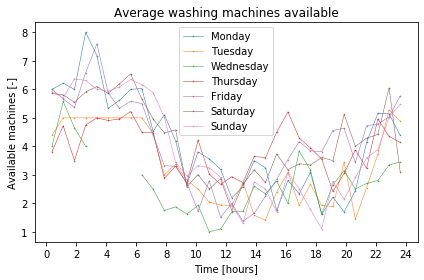

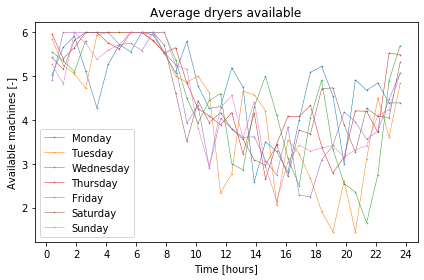

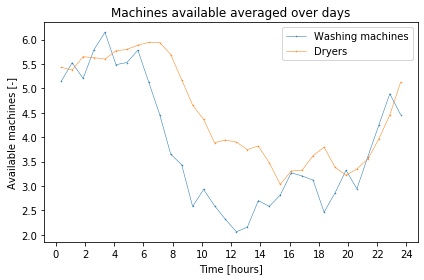

In [136]:
# Options for data
timestep = 45 # minutes

# Options for formatting
titles = ("Average dryers available","Average washing machines available","Machines available averaged over days")
marker_size = 1
line_width = 0.5
fmt = '.-'

# Create figures; one for the washing machines, one for the dryer, one average of both.
fig_washing = plt.figure()
ax_washinig = fig_washing.add_subplot(1, 1, 1)

fig_drying = plt.figure()
ax_drying = fig_drying.add_subplot(1, 1, 1)

fig_days = plt.figure()
ax_days = fig_days.add_subplot(1, 1, 1)

# Create arrays for timestep averaged data (so we can keep the other array)
averaged_washing = np.zeros((len(day_list), np.ceil(washing.size/len(day_list)/timestep).astype(int)))
averaged_drying = np.zeros((len(day_list), np.ceil(drying.size/len(day_list)/timestep).astype(int)))
averaged_time = np.zeros((len(day_list), np.ceil(time_corrected.size/len(day_list)/timestep).astype(int)))

# Calculate average machine use in timestep minutes
for d, day in enumerate(day_list):
    # Take the mean of every timestep minutes for both arrays
    averaged_washing[d] = np.nanmean(np.pad(washing[d], 
                            (0, timestep - washing[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    averaged_drying[d] = np.nanmean(np.pad(drying[d], 
                            (0, timestep - drying[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    averaged_time[d] = np.nanmean(np.pad(time_corrected[d], 
                            (0, timestep - time_corrected[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    
    # Yeet it into a plot
    ax_washinig.plot(averaged_time[d]/60, averaged_washing[d], fmt, ms=marker_size, lw=line_width, label=day)
    ax_drying.plot(averaged_time[d]/60, averaged_drying[d], fmt, ms=marker_size, lw=line_width, label=day)
ax_days.plot(np.nanmean(averaged_time, axis=0)/60, np.nanmean(averaged_washing, axis=0), fmt, ms=marker_size, lw=line_width, label="Washing machines")
ax_days.plot(np.nanmean(averaged_time, axis=0)/60, np.nanmean(averaged_drying, axis=0), fmt, ms=marker_size, lw=line_width, label="Dryers")

ax = (ax_drying, ax_washinig, ax_days)
fig = (fig_drying, fig_washing, fig_days)

for ax, fig, name in zip(ax, fig, titles):
    ax.legend()
    ax.set_xlabel(r"Time [hours]")
    ax.set_ylabel(r"Available machines [-]")
    ax.set_title(r"%s"%name)
    ax.set_xticks(np.arange(0,25,2))
    #ax.set_xlim((15, 18))
    fig.tight_layout()
    fig.savefig(("%s.png"%name).replace(" ", "_"), dpi=400)
    fig.show()
    

### Correlation between washing machines and dryers

Noise is poisonian: noise comes from failing of server which happens at random.

This correlation peaks after 1.000 hours.


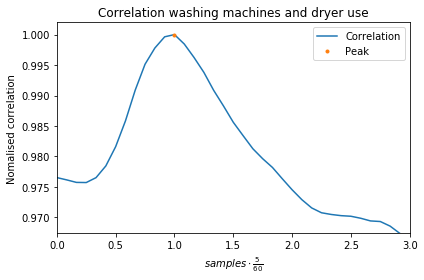

In [138]:
window_time = np.array([0, 3]) # 'hours'
polling_time = 5

correlate = signal.correlate(data["Dryers free"], data["Machines free"])
correlate /= np.max(correlate)

part = correlate[int(correlate.size/2+window_time[0]*60/polling_time):int(correlate.size/2+window_time[1]*60/polling_time)]

peak = np.argmax(part)
print("This correlation peaks after %0.3f hours."%(peak*polling_time/60+window_time[0]))

time_array = (np.arange(correlate.size)-np.floor(correlate.size/2))
plt.plot(time_array*polling_time/60, correlate, label="Correlation")
plt.plot((peak)*polling_time/60+window_time[0], part[int(peak)], '.', label="Peak")

plt.xlabel(r"$samples\cdot\frac{%d}{60}$"%polling_time)
plt.ylabel(r"Nomalised correlation")
plt.xlim((*window_time))
plt.ylim((np.min(part), 1.002*np.max(part)))
plt.title("Correlation washing machines and dryer use")
plt.legend()
plt.tight_layout()
plt.savefig(("Correlation washing machines and dryer use.png").replace(" ", "_"), dpi=400)
plt.show()

### Rate of change in use

The idea is that the rate of change in use corresponds to activity. Idea: sum both datasets and apply low pass filter to see trends.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


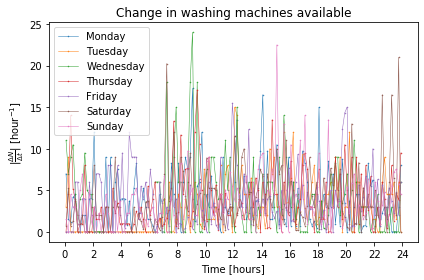

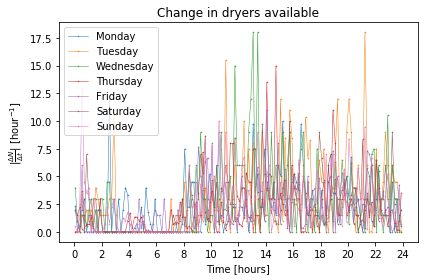

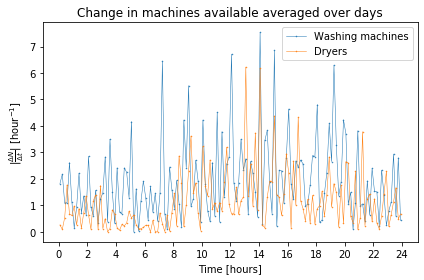

In [145]:
# Options for data
timestep = 10 # minutes

# Options for formatting
titles = ("Change in dryers available","Change in washing machines available","Change in machines available averaged over days")
marker_size = 1
line_width = 0.5
fmt = '.-'

# Create figures; one for the washing machines, one for the dryer, one average of both.
fig_washing = plt.figure()
ax_washinig = fig_washing.add_subplot(1, 1, 1)

fig_drying = plt.figure()
ax_drying = fig_drying.add_subplot(1, 1, 1)

fig_days = plt.figure()
ax_days = fig_days.add_subplot(1, 1, 1)


# Create arrays for timestep averaged data (so we can keep the other array)
averaged_washing = np.zeros((len(day_list), np.ceil(washing.size/len(day_list)/timestep).astype(int)))
averaged_drying = np.zeros((len(day_list), np.ceil(drying.size/len(day_list)/timestep).astype(int)))
averaged_time = np.zeros((len(day_list), np.ceil(time_corrected.size/len(day_list)/timestep).astype(int)))
change_washing = np.zeros((len(day_list), np.ceil(washing.size/len(day_list)/timestep).astype(int)))
change_drying = np.zeros((len(day_list), np.ceil(drying.size/len(day_list)/timestep).astype(int)))

for d, day in enumerate(day_list):
    # Take the mean of every timestep minutes for both arrays
    averaged_washing[d] = np.nanmean(np.pad(washing[d], 
                            (0, timestep - washing[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    averaged_drying[d] = np.nanmean(np.pad(drying[d], 
                            (0, timestep - drying[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    averaged_time[d] = np.nanmean(np.pad(time_corrected[d], 
                            (0, timestep - time_corrected[d].size%timestep), 
                            mode='constant', 
                            constant_values=np.NaN).reshape(-1, timestep), 
                     axis=1)
    
    # Calculate the difference
    change_washing[d] = (averaged_washing[d]-np.roll(averaged_washing[d], -1))/(timestep/60)
    change_drying[d] = (averaged_drying[d]-np.roll(averaged_drying[d], -1))/(timestep/60)
    
    # Yeet it into a plot
    ax_washinig.plot(averaged_time[d]/60, np.abs(change_washing[d]), fmt, ms=marker_size, lw=line_width, label=day)
    ax_drying.plot(averaged_time[d]/60, np.abs(change_drying[d]), fmt, ms=marker_size, lw=line_width, label=day)
ax_days.plot(np.nanmean(averaged_time, axis=0)/60, np.abs(np.nanmean(change_washing, axis=0)), fmt, ms=marker_size, lw=line_width, label="Washing machines")
ax_days.plot(np.nanmean(averaged_time, axis=0)/60, np.abs(np.nanmean(change_drying, axis=0)), fmt, ms=marker_size, lw=line_width, label="Dryers")

ax = (ax_drying, ax_washinig, ax_days)
fig = (fig_drying, fig_washing, fig_days)

for ax, fig, name in zip(ax, fig, titles):
    ax.legend()
    ax.set_xlabel(r"Time [hours]")
    ax.set_ylabel(r"$|\frac{\Delta N}{\Delta t}|$ [hour$^{-1}$]")
    ax.set_title(r"%s"%name)
    ax.set_xticks(np.arange(0,25,2))
    #ax.set_xlim((15, 18))
    fig.tight_layout()
    fig.savefig(("%s.png"%name).replace(" ", "_"), dpi=400)
    fig.show()

In [144]:
def plot_density(key, div=1, logarithmic=False, cmap='viridis', return_density=False, xlabel = None, ylabel= None, title=None, plot_missing_data=False):
    density_washing = np.zeros(
        (int(np.max(data["Machines free"])-np.min(data["Machines free"])),
         int(np.max(data[key])/div-np.min(data[key])/div))
    )
    density_drying = np.zeros(
        (int(np.max(data["Dryers free"])-np.min(data["Dryers free"])),
         int(np.max(data[key])/div-np.min(data[key])/div))
    )

    for i in np.arange(np.max(data[key])/div-np.min(data[key])/div, dtype=int):
        t = np.min(data[key]/div) + i
        for j in np.arange(np.max(data["Machines free"])-np.min(data["Machines free"]), dtype=int):
            density_washing[j,i] = (np.sum(
                (data[key]/div==np.min(data[key])/div + i)
                *(data["Machines free"]==np.min(data["Machines free"]) + j)
            )/np.sum(data[key]/div==np.min(data[key])/div + i)
                                   )
        for j in np.arange(np.max(data["Dryers free"])-np.min(data["Dryers free"]), dtype=int):
            density_drying[j,i] = (np.sum(
                (data[key]/div==np.min(data[key])/div + i)
                *(data["Dryers free"]==np.min(data["Dryers free"]) + j)
            )/np.sum(data[key]/div==np.min(data[key])/div + i)
                                  )
    
    if plot_missing_data == False:
        density_washing[density_washing==0]=np.nan
        density_drying[density_drying==0]=np.nan
    
    #Create figures
    fig_washing = plt.figure()
    ax_washing = fig_washing.add_subplot(1, 1, 1)

    fig_drying = plt.figure()
    ax_drying = fig_drying.add_subplot(1, 1, 1)

    # Maxe ax arrays to make plotting more easy
    ax = (ax_drying, ax_washing)
    fig = (fig_drying, fig_washing)

    # Plot the density
    if logarithmic == True:
        ax_washing.matshow(np.log(density_washing), aspect='auto')
        ax_drying.matshow(np.log(density_drying), aspect='auto')
    else:
        ax_washing.matshow(density_washing, aspect='auto')
        ax_drying.matshow(density_drying, aspect='auto')

    # Format and show the images
    for ax, fig, name in zip(ax, fig, ("dryer","washing machine")):
        if xlabel == None:
            ax.set_xlabel(r"%s"%key)
        else:
            ax.set_xlabel(xlabel)
            
        if ylabel == None:
            ax.set_ylabel(r"Available %ss"%name)
        else:
            ax.set_ylabel(ylabel)
        
        if title == None:
            ax.set_title(r"%s density of %s use"%(key, name), y=1.15)
        else:
            ax.set_title(title+r", %s use"%(name), y=1.15)
        ax.ticklabel_format(axis='x',useOffset=np.min(data[key])/div)
        ax.ticklabel_format(axis='y',useOffset=np.min(data["Machines free"]))
        
        fig.tight_layout()
        fig.savefig(("%s density %s.png"%(key, name)).replace(" ", "_"), dpi=400)
        fig.show()
    
    if return_density==True:
        return density_washing, density_drying
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


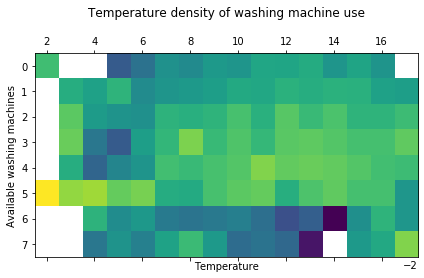

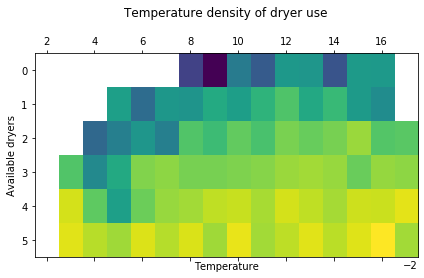

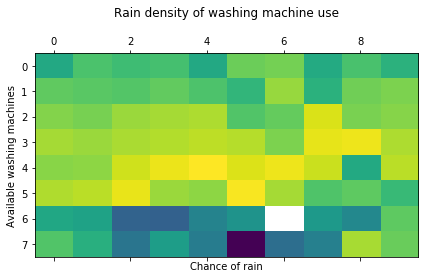

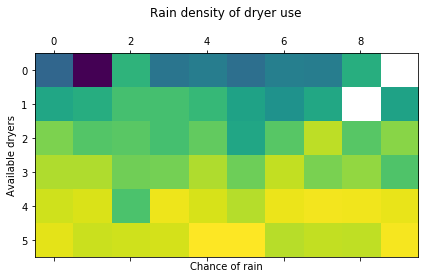

In [140]:
plot_density("Temperature", logarithmic=True)
plot_density("Rain", logarithmic=True, div=10, xlabel=r"Chance of rain")